# DeepHarmony - Experiments on music genre classification with deep neural networks

Group project for the Deep Learning course held by Prof. Matteo Ferrara.

Group members:


*   Marzoli Leo
*   Nediani Gian Luca
*   Pirazzoli Federico



# Introduction + Context

This project aims to apply the deep learning techniques acquired during the course to the musical domain by training a neural network capable of accurately predicting the genre of given audio tracks. The focus will be on investigating two main aspects:

1. What impact does the duration of audio files have on the network's performance?
2. Is it feasible to segment the available tracks to obtain more examples? What impact does this have on performance compared to using non-segmented songs?

Due to the scarcity of publicly available music datasets, the project's first task is to create one using a web scraping approach to collect royalty-free music from online archives. Once an adequately sized dataset is created, it will be pre-processed and used to train and evaluate the neural networks and run the experiments.

Project installs:

In [ ]:
!pip install pydub
!pip install gdown
!pip install keras_nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 80.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 91.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 76.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 77.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 38.2 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Suc

# 1. Web scraping

As previously said, unfortunately due to the lack of music datasets online, both having a baseline and multiple testing grounds for possible models and strategies is lacking, therefore for a part of the project itself we decided to create one ourselves, by using freely available music online, more specifically we took advantage of the ever more presence of royalty free music. Because of the way most entertainment is produced nowadays, royalty free music websites offer an easy way to obtain music that won't be eligible for copyright strikes, and that's exactly what we did.

The website we made use of is called [FreeMusicArchive](https://freemusicarchive.org/home) which, as previously stated, hosts a variety of royalty free music, and together through the use of Web Scraping, we managed to download 36K+ songs to analyze and elaborate.

## Mock Code Used

Because of the very nature of Web Scraping, we spent around 3 weeks gathering the songs for our dataset, by employing a script, written in Python, that would make, explained very simply, perform GET calls onto a selection of filtered songs, download the payload, the mp3 file, if present and usable with our feature extracting library, and finally save it locally. We also made sure that the website itself allowed for bots and scripts to be used (this can generally be done by visiting a certain URL, called ***/robots.txt***, of the website we want to scrape, e.g. www.google.com/robots.txt), and also that we didn't overload with traffic the destination website.

Also we made sure, when filtering the songs to download, to only scrape songs that fell under proper licensing, which means all of the songs that we've used, inherently can be used for any kind of purpose, be they commercial or not. This is something we wanted to make sure of to obviously have a legal and also ethical approach to the artists that let us use their content.

Here below we will put some code that has been used, for knowledge reasons, but obviously, it's not meant to be run within this notebook, more just to show off the modus operandi used during this process.

In [ ]:
import pydub
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import requests
import re
import os
import time
import csv
import unicodedata

In [ ]:
# This function here is meant to transform a given string into a UNICODE compatible one, which we used later on to properly produce a safe name for the mp3 files to save.

def slugify(value, allow_unicode=False):
    value = str(value)
    if allow_unicode:
        value = unicodedata.normalize('NFKC', value)
    else:
        value = unicodedata.normalize('NFKD', value).encode('ascii', 'ignore').decode('ascii')
    value = re.sub(r'[^\w\s-]', '', value.lower())
    return re.sub(r'[-\s]+', '-', value).strip('-_')

In [ ]:
# These instructions here made sure to use a certain directory, more specifically the one the notebook was in, in order to perform save operations more easily
# which have no use in this here notebook

# abspath = os.path.abspath(__file__)
# dname = os.path.dirname(abspath)
# os.chdir(dname)

In [ ]:
# Then here the URL used to get songs in batches of 200 and process them, by again doing a GET call on it and exploring the HTML obtained
page = "1"
urlToOpen = "https://freemusicarchive.org/search?adv=1&search-genre=Blues%2CHip-Hop%2CJazz%2CRock%2CClassical%2CCountry%2CFolk%2CPop%2CElectronic&music-filter-CC-attribution-only=1&music-filter-CC-attribution-sharealike=1&music-filter-CC-attribution-noncommercial=1&music-filter-CC-attribution-noncommercial-sharealike=1&pageSize=200&page=" + page


# This part here will obtain the HTML of the main filter page which contains batches of 200 songs, save it in a variable and then close the connection

req = Request(
    url=urlToOpen,
    headers={'User-Agent': 'Mozilla/5.0 (Windows NT 10.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36'}
)

with urlopen(req) as webPageResponse:
    contents = webPageResponse.read()

webPageResponse.close()


# Here the HTML will get loaded with the BeautifulSoup library

beautifulSoupText = BeautifulSoup(contents, 'lxml')

main = beautifulSoupText.find_all("div", attrs={"class": ["play-item", "justify-center", "items-center", "relative", "bg-[#F8F8F8]", "gcol", "grid",
                                                  "grid-cols-3", "md:grid-cols-10", "pl-16", "pr-2", "py-3", "w-full", "gid-electronic"]})


Now I will introduce the bigger portion of the code, dedicated to obtain the HTML of the previously declared URL, process the HTML to obtain various information from the songs present on there such as the name of the song, the name of the artist, the name of the album and the genre it belongs to. The library used to parse the HTML that we got, is called BeautifulSoup, which lets us do exactly that.

In [ ]:
# for i in range(20, len(main) - 3):
i = 20

# This piece of code right here is meant to be run with a loop, as seen above, where 200 songs from the page previously obtained will be processed, here for demonstration purposes only
# one song will be processed




# Here as you can see I'm simply parsing the webpage to look for the correspondent information

songName = main[i].find("span", attrs={"class": ["ptxt-track"]}).find("a").text.replace("\n", "").replace("|", "")
artistName = main[i].find("span", attrs={"class": ["ptxt-artist", "truncate", "text-ellipsis", "overflow-hidden"]}).find_all("span")[1].find("a").text.replace("\n", "").replace("|", "")
trackLink = main[i].find("span", attrs={"class": ["ptxt-track"]}).find("a").get("href")

songGenres = []

# These 2 variables are set up for later use, in case the links provided to download the song are broken, or the song itself
# it's downloaded in a unusuable format

skipSong = False
skipTrimming = False

for row in main[i].find("span", attrs={"class": ["ptxt-genre"]}).find_all("a"):
    songGenres.append(row.text)


trackPage = Request(
    url=trackLink,
    headers={'User-Agent': 'Mozilla/5.0 (Windows NT 10.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36'},
    )

# This is the first check, done to access the main song page to then access the download link

try:
    with urlopen(trackPage) as webPageResponse:
        trackPageContent = webPageResponse.read()

    webPageResponse.close()
except:
    skipSong = True

if not skipSong:

    beautifulSoupTrackPage = BeautifulSoup(trackPageContent, 'lxml')

    fileNameDiv = beautifulSoupTrackPage.select("div.flex.items-center.gap-4.px-4.py-2.bg-gray-light.py-4.rounded.mx-auto.w-full.gcol.gid-electronic")[0].get("data-track-info")
    downloadLink = re.search('"fileUrl":"(.*)"', fileNameDiv).group(1).replace("\\", "") + "?download=1"

    # Use 'with' to ensure the session context is closed after use.
    # Also this block of code is required, since to perform downloads on the website, an actual account is needed, therefore
    # I signed up for free and used my credentials to create a log in token, as it can be seen in the 'payload' dictionary below
    with requests.Session() as s:
        s.headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36'}
        tokenPage = s.get("https://freemusicarchive.org/login")
        token = re.search('value="(.*)"> ', tokenPage.text[tokenPage.text.find("_token"):]).group(1)

        payload = {
            '_token': token,
            'email': 'zarkon92@hotmail.it',
            'password': 'F7kWWi/5v2-RbSb'
        }

        p = s.post('https://freemusicarchive.org/login', data=payload)

        if p.history:
            print("Request was redirected")
            for resp in p.history:
                print(resp.status_code, resp.url)
            print("Final destination:")
            print(p.status_code, p.url)
        else:
            print("Request was not redirected")


        r = s.get(
            url=downloadLink,
            headers={'User-Agent': 'Mozilla/5.0 (Windows NT 10.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36'},
            allow_redirects=True
            )


        with open("./content" + slugify(songName + " " + artistName) + " toTrim.mp3", 'wb') as f:
            f.write(r.content)


        # This is the second check, where we make sure that the song we downloaded it's usuable, and if it is, we cut a 30 second segment from the middle of the song
        # which then will be saved for later use

        try:
            audio = pydub.AudioSegment.from_mp3("./content" + slugify(songName + " " + artistName) + " toTrim.mp3")
        except:
            print("Songs is non processable")
            skipTrimming = True

        if not skipTrimming:

            if audio.duration_seconds <= 30:
                startTime = 0
                endTime = audio.duration_seconds
            else:
                startTime = (audio.duration_seconds / 2) - 15
                endTime = startTime + 30

            centralPart = audio[startTime * 1000 : endTime * 1000]

            centralPart.export("./content" + slugify(songName + " " + artistName) + ".mp3", format="mp3")


            if os.path.exists("./content" + slugify(songName + " " + artistName) + " toTrim.mp3"):
                os.remove("./content" + slugify(songName + " " + artistName) + " toTrim.mp3")

            # This final sleep was to create enough delay to not overload the websites servers with traffic

            time.sleep(0.3)

Request was redirected
302 https://freemusicarchive.org/login
302 https://freemusicarchive.org//
Final destination:
200 https://freemusicarchive.org/


Also this line of code is used to clear Colabs memory after trying out the Web Scraping

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


The code provided was, more or less, what was used to download the songs and create the dataset. As previously stated, we parsed through 49K songs, of which 38K were usable, all taking 3 weeks, since obviously each download required some time, and which was unfortunately quite uneven, in terms of the number of songs per genre, as seen below.

Number of songs per genres:
*   Blues: 1008
*   Classical: 1710
*   Country: 402
*   Electronic: 14895
*   Hip-Hop: 2101
*   Jazz: 1870
*   Pop: 5078
*   Rock: 6450

## Data download using gdown

The cells below will download the following content in order:
*   songs1710.npy, containing already the features extracted from our custom made dataset, in order to save time on testing;
*   songs1710, which is a folder containing all the songs used to extract the features needed for testing.



In [ ]:
!gdown 1b3aDSdAjKpbyl0cxD-qP-7qtL7s7fCIn
!unzip songs1710.zip

!rm songs1710.zip

Downloading...
From (original): https://drive.google.com/uc?id=1b3aDSdAjKpbyl0cxD-qP-7qtL7s7fCIn
From (redirected): https://drive.google.com/uc?id=1b3aDSdAjKpbyl0cxD-qP-7qtL7s7fCIn&confirm=t&uuid=d3344ff9-2a6f-493c-9a74-8c1d4c0c7ad4
To: /content/songs1710.zip
100% 3.96G/3.96G [01:12<00:00, 54.5MB/s]
Archive:  songs1710.zip
  inflating: songs1710.npy           


In [ ]:
!gdown 178mFuNGe7PhtFdvftsDWZLi0BqxHlx4k
!unzip songs1710_whole.zip

!rm songs1710_whole.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: songs1710/jazz/bukovina-the-underscore-orkestra.mp3  
  inflating: songs1710/jazz/bullfrog-inside-wheelbarrow-laughs-hat-city-intuitive.mp3  
  inflating: songs1710/jazz/bumping-bingo-id-1434-lobo-loco.mp3  
  inflating: songs1710/jazz/bungee-jump-id-2036-lobo-loco.mp3  
  inflating: songs1710/jazz/buoyant-dee-yan-key.mp3  
  inflating: songs1710/jazz/buried-in-the-garden-pregnant.mp3  
  inflating: songs1710/jazz/burlington-goat-factory-bronhardgoingpublic.mp3  
  inflating: songs1710/jazz/burning-tri-tachyon.mp3  
  inflating: songs1710/jazz/business-trip-dee-yan-key.mp3  
  inflating: songs1710/jazz/buskers-dee-yan-key.mp3  
  inflating: songs1710/jazz/busy-bees-dee-yan-key.mp3  
  inflating: songs1710/jazz/butterflies-dee-yan-key.mp3  
  inflating: songs1710/jazz/by-the-coast-2004-antony-raijekov.mp3  
  inflating: songs1710/jazz/byrons-reward-is-drunk-and-stupid-jared-c-balogh.mp3  
  inflating: songs1710/jazz/c-est-pa

# 2. Feature extraction


## Librosa

[Librosa](https://github.com/librosa/librosa) is a popular Python package for music and audio analysis. It will be used here to extract features from the music file. These features will be then fed as input for the classifier training and evaluation.



In [ ]:
import librosa

All the songs present in the dataset use a sample rate of 22050khz, with no exception. This will therefore be set as the working sample rate while extracting and visualizing features from the songs.

In [ ]:
SAMPLE_RATE = 22050

Load an audio file as a floating point time series.

In [ ]:
path = '/content/songs1000/blues/a-cry-at-sea-cullah.mp3'
y, sr = librosa.load(path, sr = SAMPLE_RATE)

The length of y is influenced by the chosen sample rate, with a higher sampling rate leading to a more precise representation:

In [ ]:
print(y.shape)

(141263,)


## Feature explanation

In this section, some of the features that can be extracted with librosa (mostly the ones used to train the models) are shown and explained.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

### Sound waves

Sound waves are the physical vibrations of particles in an elastic medium, such as air or water, that propagate through the medium and transmit energy. With the *waveshow()* the waves can be displayed graphically.

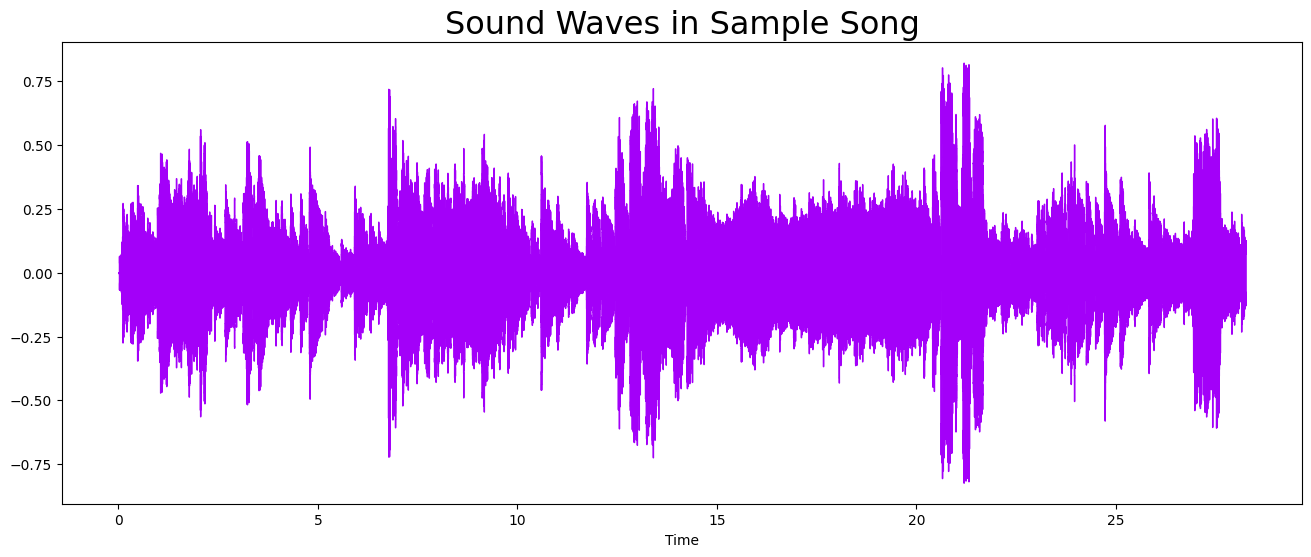

In [ ]:
plt.figure(figsize = (16, 6))
librosa.display.waveshow(y=y, sr=SAMPLE_RATE, color="#A300F9")
plt.title("Sound Waves in Sample Song", fontsize = 23);

### Spectrogram

A spectrogram is a visual representation of the spectrum of frequencies in a sound signal as it varies over time. With the *specshow()* function, a two-dimensional plot where the horizontal axis represents time, the vertical axis represents frequency, and the intensity or color represents the amplitude of each frequency component can be displayed.

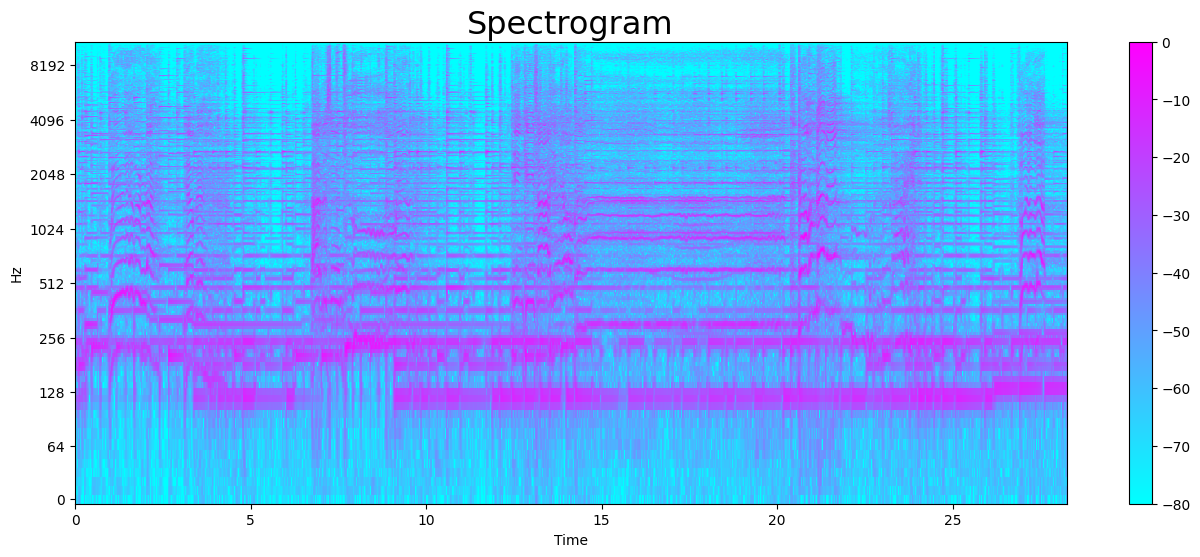

In [ ]:
n_fft = 2048 # FFT window size
hop_length = 512 # number audio of frames between STFT columns

# Short-time Fourier transform (STFT)
D = np.abs(librosa.stft(y, n_fft = n_fft, hop_length = hop_length))

DB = librosa.amplitude_to_db(D, ref = np.max)

plt.figure(figsize = (16, 6))
librosa.display.specshow(DB, sr = sr, hop_length = hop_length, x_axis = 'time', y_axis = 'log',
                        cmap = 'cool')
plt.title("Spectrogram", fontsize=23)
plt.colorbar();

### Mel spectrogram

A Mel spectrogram is a type of spectrogram where the frequency scale is warped according to the Mel scale, which is a perceptual scale of pitch that more closely matches the way the human ear perceives sound.

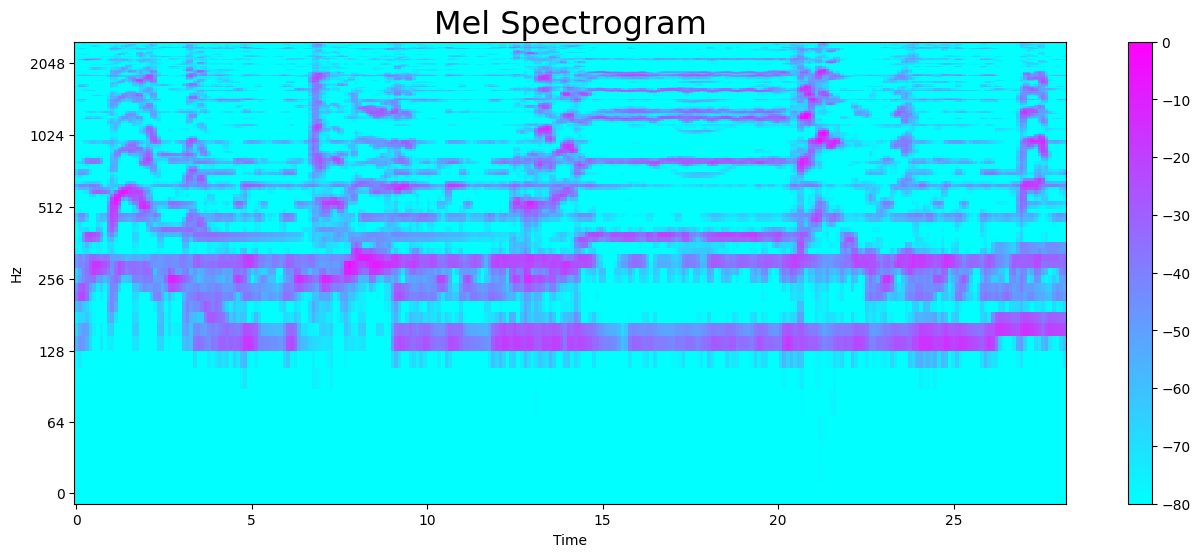

In [ ]:
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)

plt.figure(figsize=(16, 6))
librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Mel Spectrogram", fontsize=23)
plt.show()

### Tempo (BPM)

Tempo, measured in beats per minute (BPM), refers to the speed or pace of a piece of music.

In [ ]:
tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
tempo

array([83.70535714])

### Spectral centroids

The spectral centroid is a measure of the "brightness" of a sound. It represents the weighted average of the frequencies present in the sound, with the weights being the amplitudes of the corresponding frequency components.

In [ ]:
spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]

print('First 10 centroids:', spectral_centroids[:10], '\n')
print('Shape of Spectral Centroids feature:', spectral_centroids.shape, '\n')

First 10 centroids: [687.0421586  731.24337152 754.77360542 752.20168674 732.11059471
 701.18108396 715.68469818 755.25592249 801.31919601 782.7227561 ] 

Shape of Spectral Centroids feature: (276,) 



### Spectral bandwidth

Spectral bandwidth is a measure of the width of the signal's frequency spectrum, indicating the range of frequencies present in the signal. The function computes the second central moment (variance) of the spectrum's magnitude, which quantifies the spread of the spectral energy around its mean frequency

### Spectral rolloff

Spectral rolloff is a measure of the frequency below which a certain percentage (set by default at 85%) of the total spectral energy is contained.

In [ ]:
spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
spectral_rolloff[:10]

array([[3046.94824219, 2648.58398438, 3186.9140625 , ..., 3692.94433594,
        3692.94433594, 3682.17773438]])

### Chroma frequencies (chromagram)

A chromagram is a representation of the musical content in an audio signal. It is obtained by using the Short-Time Fourier Transform (STFT) to compute the spectral content of the audio, and then mapping the resulting frequencies to a set of 12 pitch classes, which correspond to the notes in the Western chromatic scale (A, A#, B, C, C#, D, D#, E, F, F#, G, G#).

The Chromagram is a matrix where each row corresponds to one of the 12 pitch classes, and each column corresponds to a time frame. The values in the matrix represent the intensity or presence of each pitch class in each time frame.

Chromogram shape: (12, 1217)


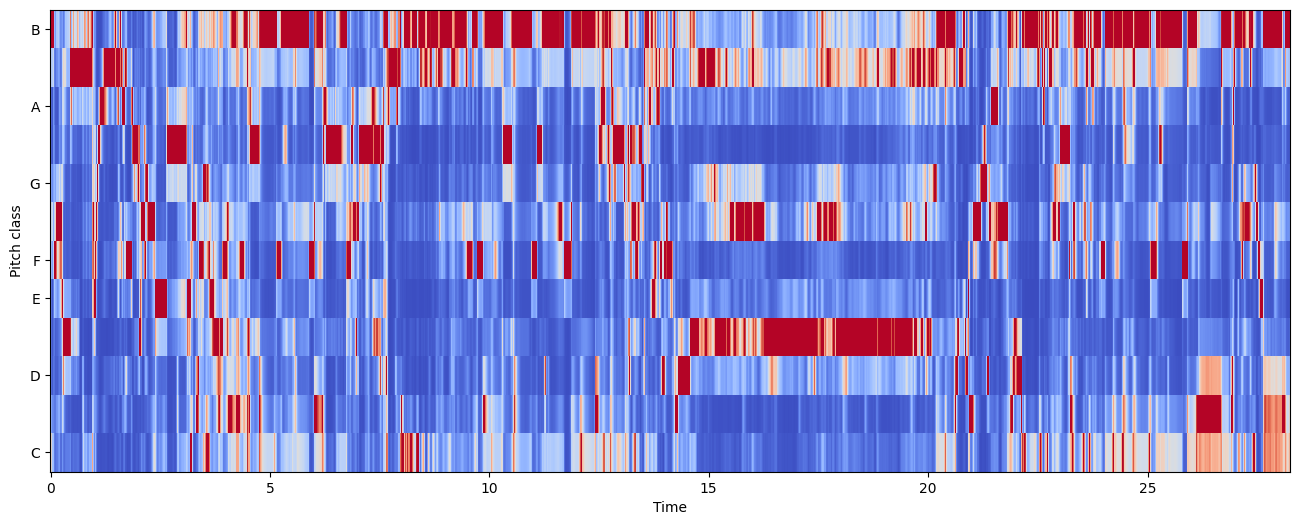

In [ ]:
hop_length = 128

chromagram = librosa.feature.chroma_stft(y=y, sr=sr)
print('Chromogram shape:', chromagram.shape)

plt.figure(figsize=(16, 6))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', cmap='coolwarm');

### Zero-crossing rate

The zero-crossing rate is a measure of the number of times an audio signal's amplitude crosses zero in a given time frame. It's used to detect changes in the signal, such as onsets and offsets of musical notes or speech sounds.

In [ ]:
zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y)
zero_crossing_rate[:, :10]

array([[0.05322266, 0.06054688, 0.08740234, 0.08886719, 0.11572266,
        0.12304688, 0.1171875 , 0.11083984, 0.10693359, 0.12792969]])

### Root-mean-square (RMS)

Computes the root-mean-square (RMS) value for each frame

In [ ]:
rms = librosa.feature.rms(y=y)
rms.shape

(1, 1217)

### Polynomial features

Get coefficients of fitting an nth-order polynomial to the columns of a spectrogram

In [ ]:
poly_features = librosa.feature.poly_features(y=y, sr=sr)

### Tonal centroid features

Compute the tonal centroid features, also knwon as *tonnetz*.

In [ ]:
tonnetz = librosa.feature.tonnetz(y=y)

# 3. Data pre-processing and dataset creation

We first load the dataset into memory by either extracting it manually using the cell block below, or using the already extracted features from the .npy file in order to save time.

We recommend to take a look at the save_features method below, but not use it as it will take a lot of time to extract all almost 12K songs present in the songs1710 folder, therefore we suggest to use the cells after which will load the songs1710.npy numpy file which will contain the features already extracted.

### Extract features

In [ ]:
import os
import soundfile as sf
import librosa
import time
import numpy as np

The cell below contains the main properties to consider during feature extraction, using the library Librosa:


1.   Sample Rate, which indicates how accurate are the measurements and feature extractions operations performed by Librosa, obviously the higher the better;
2.   Duration, indicates the length of the song to extract, and since each song is 30 seconds, we write 30.



In [ ]:
SAMPLE_RATE = 22050
DURATION = 30

In [ ]:
def save_features(dataset_path, batch_size=100):
    # Initialize the combined features and labels array
    data = []
    labels = []
    # Create a mapping of labels to numeric indices
    label_to_index = {}
    # Initialize counters
    num_valid = 0
    num_invalid = 0
    counter = 0

    # Loop through all the genres
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath != dataset_path:
            # Save the semantic label
            dirpath_comp = dirpath.split("/")
            semantic_label = dirpath_comp[-1]
            # Create a mapping of labels to numeric indices
            if semantic_label not in label_to_index:
                label_to_index[semantic_label] = len(label_to_index)

            # Process files for specific genre in batches
            for batch_start in range(0, len(filenames), batch_size):
                batch_end = min(batch_start + batch_size, len(filenames))
                batch_files = filenames[batch_start:batch_end]
                for f in batch_files:
                    # Load audio file
                    file_path = os.path.join(dirpath, f)
                    try:
                        y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
                    except FileNotFoundError:
                        print(f"File not found: {file_path}")
                        continue
                    except sf.LibsndfileError:
                        print(f"Error loading file: {file_path}")
                        continue

                    # Segment the audio file into 5 equal parts
                    num_segments = 1
                    segment_size = int(len(y) / num_segments)
                    for j in range(num_segments):
                        start_time = time.time()  # start the timer
                        start = j * segment_size
                        end = (j + 1) * segment_size
                        if j == num_segments - 1:  # For the last segment, include the remaining part of the audio
                            end = len(y)
                        segment = y[start:end]

                        # Extract features
                        mfcc = librosa.feature.mfcc(y=segment, sr=sr)
                        spectral_centroid = librosa.feature.spectral_centroid(y=segment, sr=sr)
                        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=segment, sr=sr)
                        zero_crossing_rate = librosa.feature.zero_crossing_rate(y=segment)
                        chroma = librosa.feature.chroma_stft(y=segment, sr=sr)
                        mel = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=16)
                        tempo, beats = librosa.beat.beat_track(y=segment, sr=sr)
                        rms = librosa.feature.rms(y=segment)
                        spectral_rolloff = librosa.feature.spectral_rolloff(y=segment, sr=sr)
                        poly_features = librosa.feature.poly_features(y=segment, sr=sr)
                        tonnetz = librosa.feature.tonnetz(y=segment)

                        # Repeat the scalar values n times
                        n = zero_crossing_rate.shape[1]  # Number of frames
                        tempo_reshaped = np.repeat(tempo, n).reshape(1, -1)
                        beats_reshaped = np.tile(np.expand_dims(beats, axis=1), (1, mfcc.shape[1]))
                        beats_trimmed = beats_reshaped[:9, :]


                        print(f"Features shape for stacking: ")
                        print(f"Mfcc {np.array(mfcc).shape}")
                        print(f"Spectral Centroid {np.array(spectral_centroid).shape}")
                        print(f"Spectral Bandwidth {np.array(spectral_bandwidth).shape}")
                        print(f"Zero Crossing Rate{np.array(zero_crossing_rate).shape}")
                        print(f"Chroma {np.array(chroma).shape}")
                        print(f"Mel {np.array(mel).shape}")
                        print(f"Tempo {np.array(tempo_reshaped).shape}")
                        print(f"RMS {np.array(rms).shape}")
                        print(f"Spectral Rolloff {np.array(spectral_rolloff).shape}")
                        print(f"Poly Features {np.array(poly_features).shape}")
                        print(f"Tonnetz {np.array(tonnetz).shape}")


                        # Stack the features
                        features = np.vstack([mfcc, spectral_centroid, spectral_bandwidth, zero_crossing_rate, chroma, mel,
                                              tempo_reshaped, rms, spectral_rolloff, poly_features, tonnetz])
                        features = np.transpose(features, (1, 0))
                        print("features:", features.shape)

                        # Add the features and label to the data list
                        size_dim_zero = 1150
                        if features.shape[0] > size_dim_zero:
                            data.append(features[:size_dim_zero, :])
                            print("appending:" + str(features[:size_dim_zero, :].shape))
                            labels.append(i-1)
                            num_valid += 1
                            print(f"Processing: {file_path}")
                        elif features.shape[0] == size_dim_zero:
                            data.append(features)
                            print("appending:" + str(features.shape))
                            labels.append(i-1)
                            num_valid += 1
                            print(f"Processing: {file_path}")
                        else:
                            num_invalid += 1
                            print(f"Invalid shape: {features.shape} for file: {file_path}")
                        counter = counter + 1
                        print("Counter:", counter)
                        end_time = time.time()  # end the timer
                        processing_time = end_time - start_time  # calculate the processing time
                        print(f"Time required to process segment {j+1}: {processing_time} seconds")
                        print("\n")

    print(f"Number of files processed successfully: {num_valid}")
    print(f"Number of files with invalid shapes: {num_invalid}")

    # Convert the data list to a NumPy array
    data = np.array(data)
    labels = np.array(labels)
    return data, labels

In [ ]:
from IPython.display import clear_output
data, labels = save_features("./songs1710")
clear_output()

### Load Features from File

In [ ]:
with open('songs1710.npy', 'rb') as f:
    data = np.load(f)
    labels = np.load(f)

In [ ]:
data.shape, labels.shape

((11205, 1150, 62), (11205,))

## Outlier handling

In order to remove the outliers from the dataset, we will first import the zscore function to calculate the zscore of each feature, then we will cut out the outliers, replace the outliers with the mean value of each feature and then place these values back in the dataset.

In [ ]:
from scipy.stats import zscore

Two variables can be noticed in the cell block below:
*   Slices, which is an array containing the slicing necessary to do onto to data feature array that has been extracted, this is necessary because of the fact that during the features extraction, the features have been then concatenated, and we need to know which dimension corresponds with which;
*   feature_names, it's once again a simple array containing the names of the extracted features which will be used again in the cell below to identify each slicing done.

In [ ]:
slices = [20, 1, 1, 1, 12, 16, 1, 1, 1, 2, 6]
feature_names = ['mfcc', 'centroid', 'bandwidth', 'zero_crossing', 'chroma', 'mel', 'tempo', 'rms', 'rolloff', 'poly', 'tonnetz']

def transpose_feature(feature):
    if feature.ndim == 1:
        return np.expand_dims(feature, axis=1).T
    return feature.T

def slice_features(song, slices):
    features = {}
    start_index = 0

    for i, length in enumerate(slices):
        end_index = start_index + length if length > 1 else start_index + 1
        feature_name = f'feature_{i}'  # You can name your features more appropriately if needed
        features[feature_name] = transpose_feature(song[:, start_index:end_index])
        start_index = end_index

    return features

def get_features(song):
    features = slice_features(song, slices)

    features = {name: features[f'feature_{i}'] for i, name in enumerate(feature_names)}
    return features

def compute_z_scores(features):
    return {key: zscore(value, axis=1) for key, value in features.items()}

def identify_outliers(z_scores, threshold=3):
    return {key: np.abs(value) > threshold for key, value in z_scores.items()}

def delete_outliers(features, outliers):
    return {key: value[:, ~np.any(outliers[key], axis=0)] for key, value in features.items()}

def determine_target_length(features):
    return max(value.shape[1] for value in features.values())

def pad_features(feature, target_length):
    """Pad or trim the feature to the target length using the median of the array for padding."""
    median_value = np.median(feature)
    if feature.shape[1] < target_length:
        pad_width = target_length - feature.shape[1]
        feature = np.pad(feature, ((0, 0), (0, pad_width)), mode='constant', constant_values=median_value)
    else:
        feature = feature[:, :target_length]
    return feature

def pad_all_features(features, target_length):
    return {key: pad_features(value, target_length) for key, value in features.items()}

def replace_feature_data(song, feature_data, start_index, end_index):
    if feature_data.ndim > 1:
        processed_data = np.transpose(feature_data)
    else:
        processed_data = feature_data.flatten()

    song[:, start_index:end_index] = processed_data

def replace_features(song, features, slices):
    start_index = 0
    for i, length in enumerate(slices):
        end_index = start_index + length if length > 1 else start_index + 1
        replace_feature_data(song, features[feature_names[i]], start_index, end_index)
        start_index = end_index

def clip_song(song):
    features = get_features(song)
    z_scores = compute_z_scores(features)
    outliers = identify_outliers(z_scores)
    features = delete_outliers(features, outliers)
    target_length = determine_target_length(features)
    features = pad_all_features(features, target_length)
    replace_features(song, features, slices)

def handle_outliers(features):
  for song in features:
    clip_song(song)

 ## Data splitting

:This function is used to manually create the training and test sets in the form of Numpy arrays

In [ ]:
def split_data(data, labels, train_size=0.75):
    # Get unique labels and their indices
    unique_labels, indices = np.unique(labels, return_inverse=True)

    # Get a mask to sort the indices by label
    mask = np.argsort(indices)

    # Initialize lists to store train and test data and labels
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []

    # Split data and labels into training and test sets
    start = 0
    for label in unique_labels:
        label_mask = indices == label
        label_indices = mask[label_mask]
        num_examples = len(label_indices)
        train_size_for_label = int(train_size * num_examples)

        train_data.append(data[label_indices[:train_size_for_label]])
        train_labels.append(labels[label_indices[:train_size_for_label]])
        test_data.append(data[label_indices[train_size_for_label:]])
        test_labels.append(labels[label_indices[train_size_for_label:]])

    # Concatenate the lists into numpy arrays
    train_data = np.concatenate(train_data, axis=0)
    train_labels = np.concatenate(train_labels)
    test_data = np.concatenate(test_data, axis=0)
    test_labels = np.concatenate(test_labels)

    return train_data, train_labels, test_data, test_labels

## Data scaling

This function is used to perform standard scaling on the training set and test set. The scaling is performed after splitting the data into two sets to ensure that the scaling parameters (mean and standard deviation) are learned from the training data only, and not from the test data. This is important because the goal of a machine learning model is to generalize well to new, unseen data. If the scaling parameters were learned from the test data, this would leak information about the test data to the model, which could result in overfitting and poor performance on new data.

In [ ]:
from sklearn.preprocessing import StandardScaler

def standardize_data(train_data, test_data):
    train_shape = train_data.shape
    test_shape = test_data.shape

    train_data = train_data.reshape(-1, train_shape[-1])
    test_data = test_data.reshape(-1, test_shape[-1])

    scaler = StandardScaler()
    scaler.fit(train_data)

    train_data = scaler.transform(train_data)
    test_data = scaler.transform(test_data)

    if len(train_shape) > 2:
        train_data = train_data.reshape(train_shape)

    if len(test_shape) > 2:
        test_data = test_data.reshape(test_shape)

    return train_data, test_data


## Data segmentation

This function is used to segment the input data into the desired amount of segments and to repeat the corresponding labels.

In [ ]:
def segment_data(data, labels, num_segments):
    print(f"Shape of training data before segmentation: {data.shape}")
    print(f"Shape of labels: {labels.shape}")

    shape = data.shape
    print(shape)
    segmented_data = np.reshape(np.transpose(np.reshape(data, (shape[0], num_segments, int(shape[1]/num_segments), shape[2])), (0, 2, 1, 3)), (shape[0] * num_segments, int(shape[1]/num_segments), shape[2]))

    # Repeat labels
    segmented_labels = np.repeat(labels, num_segments)

    print(f"Shape of training data after segmentation: {segmented_data.shape}")
    print(f"Shape of labels: {segmented_data.shape}")

    return segmented_data, segmented_labels


# 4. Model creation

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import keras_nlp.layers as nlp_layers
from tensorflow.keras.preprocessing import text_dataset_from_directory
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from scipy.spatial import distance
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

## CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def build_cnn_model(timesteps, feature_count, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(timesteps, feature_count, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

## RNN

# **Deep RNN**
In this section a deep RNN will be created.

![alt text](https://biolab.csr.unibo.it/ferrara/Courses/DL/Tutorials/RNN/DeepRNN.png)

## **Model definition**
The following function creates a deep DNN model given:
- the number of timesteps in each input sequence (*timesteps*);
- the number of features in each timestep (*feature_count*);
- the number of units for each RNN layer (*unit_count_per_rnn_layer*).

The model returns a single target value given an entire sequence as input (*many-to-one*).

<u>Note that, the number of timesteps in each input sequence (*timesteps*) is set in advance only because it improves performance during training by creating tensors of fixed shapes. A *None* value can be used to admit variable-length input sequences.</u>

The *return_sequences* parameter of the **SimpleRNN** layer serves to return the full output time sequence (True), or only the last output (False).

In [ ]:
def build_deep_rnn(timesteps, feature_count, num_classes, unit_count_per_rnn_layer=[128, 128]):
    model = Sequential()
    model.add(layers.Input(shape=(timesteps, feature_count)))

    for i in range(len(unit_count_per_rnn_layer)):
        model.add(layers.SimpleRNN(unit_count_per_rnn_layer[i], return_sequences=True if i < (len(unit_count_per_rnn_layer) - 1) else False))

    if unit_count_per_rnn_layer[-1] > 1:
        model.add(layers.Dense(num_classes, activation='softmax'))

    return model

## Transformer

Transformers have been a breakthrough in the field of natural language processing and have recently been applied to other sequence domains, such as music. In classification cases such as this one, only the encoder part of the transformer is used, because the task here is to map an input sequence to a single output label, rather than generating a sequence of outputs as in tasks such as machine translation or music generation.

The encoder part of the transformer is responsible for processing the input sequence and extracting a set of contextualized representations, or *keys*, *values*, and *queries*, that capture the relationships between the elements of the sequence. These representations are then used to compute a weighted sum of the values for each element, which is interpreted as a context-dependent representation of the element.

In a classification task, the final context-dependent representation of the entire input sequence is used as the input to a dense layer with a softmax activation function, which maps the representation to a probability distribution over the possible output labels.

The decoder part of the transformer, which is responsible for generating a sequence of outputs, is not needed in a classification task because the output is a single label rather than a sequence.

The used architecture is as follows:
1. Input layer of size (time_steps, feature_count).
2. Positional encoding as the position in the sequence is relevant for music.
3. Four transformer encoder layers. Each encoder layer consists of a multi-head self-attention mechanism, followed by a dense layer with a ReLU activation function. The output of each encoder layer is added to the input and passed through a layer normalization and dropout layer before being passed to the next encoder layer.
4. Global average pooling to reduce the dimensionality of the data and extract a single feature vector for the entire sequence.
5. Dense layer with 512 neurons and ReLU activations.
6. Output layers with a neuron for each class (music genre) and softmax activation.


In [ ]:
def build_transformer_classifier(time_steps, feature_count, num_classes):
    input = layers.Input(shape=(time_steps, feature_count))
    pos_enc = nlp_layers.SinePositionEncoding()(input)
    add = layers.Add()([input, pos_enc])

    transf_enc = add
    for _ in range(4):
        attention_output = layers.MultiHeadAttention(key_dim=feature_count, num_heads=4)(transf_enc, transf_enc)
        attention_output = layers.LayerNormalization(epsilon=1e-6)(attention_output)
        attention_output = layers.Dropout(0.1)(attention_output)
        transf_enc = layers.Add()([transf_enc, attention_output])
        ffn_output = layers.Dense(feature_count, activation='relu')(transf_enc)
        transf_enc = layers.Add()([transf_enc, ffn_output])

    gl_avg_pool = layers.GlobalAveragePooling1D()(transf_enc)
    dense = layers.Dense(512, activation='relu')(gl_avg_pool)
    drop = layers.Dropout(rate=0.15)(dense)
    out = layers.Dense(num_classes, activation='softmax')(drop)

    model = Model(inputs=input, outputs=out)

    return model


# 5. Experiments

Utility functions:

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
def preprocess_dataset(data, labels, batch_size):
    data_clipped = data
    handle_outliers(data_clipped)
    train_data, train_labels, test_data, test_labels = split_data(data_clipped, labels)
    train_data_scaled, test_data_scaled = standardize_data(train_data, test_data)
    train_dataset = tf.data.Dataset.from_tensor_slices((train_data_scaled, train_labels))
    train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size)
    test_dataset = tf.data.Dataset.from_tensor_slices((test_data_scaled, test_labels))
    test_dataset = test_dataset.shuffle(buffer_size=10000).batch(batch_size)

    return train_dataset, test_dataset

def preprocess_dataset_segmented(data, labels, batch_size, num_segments):
    data_clipped = data
    handle_outliers(data_clipped)
    train_data, train_labels, test_data, test_labels = split_data(data_clipped, labels)
    train_data_scaled, test_data_scaled = standardize_data(train_data, test_data)
    train_data_segmented, train_labels = segment_data(train_data_scaled, train_labels, num_segments)
    test_data_segmented, test_labels = segment_data(test_data_scaled, test_labels, num_segments)
    train_dataset = tf.data.Dataset.from_tensor_slices((train_data_segmented, train_labels))
    train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size)
    test_dataset = tf.data.Dataset.from_tensor_slices((test_data_segmented, test_labels))
    test_dataset = test_dataset.shuffle(buffer_size=10000).batch(batch_size)

    return train_dataset, test_dataset

In [ ]:
def evaluate_model(model_path, test_dataset):
    """
    Evaluates a Keras model on the test dataset and calculates the confusion matrix.

    Args:
        model_path (str): Path to the saved Keras model.
        test_dataset (tf.data.Dataset): Test dataset.

    Returns:
        dict: A dictionary containing the confusion matrix, test accuracy, and test loss.
    """
    # Load the best model
    best_model = tf.keras.models.load_model(model_path)

    # Evaluate the best model on the test data
    test_loss, test_acc = best_model.evaluate(test_dataset, verbose=0)

    # Initialize lists to store true and predicted labels
    true_labels = []
    predicted_labels = []

    # Iterate over the test data in batches
    for batch_data, batch_labels in test_dataset:
        batch_predictions = best_model.predict(batch_data)
        batch_predictions = np.argmax(batch_predictions, axis=1)

        true_labels.extend(batch_labels.numpy())
        predicted_labels.extend(batch_predictions)

    # Calculate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Create a dictionary to store the results
    results = {
        'confusion_matrix': cm,
        'test_accuracy': test_acc,
        'test_loss': test_loss
    }

    return results

## 1° Esperimento

Tra gli esperimenti effettuati si è voluto creare una CNN addestrabile su immagini. In questo caso, essendo in un dominio musicale, l'immagine utilizzata per il training del modello è basato sullo spectrogramma musicale di ciascuna canzone del dataset. Di seguito si riportano i passaggi:

### Import delle librerie

In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

In [ ]:
# Parametri di configurazione
DATASET_PATH = '../input/gtzan-dataset-music-genre-classification/Data/genres_original'
OUTPUT_DIR_FOR_SPECTOGRAMS = '/kaggle/working/spectrograms'
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 20

Si definiscono delle funzioni utili allo scopo e si  riporta una breve descrizione del loro comportamento:


*   ***extract_features(file_path) :*** Questa funzione prende il percorso di un file audio come input e ne estrae il mel spectrogramma utilizzando la libreria librosa. Carica i primi 30 secondi del file, calcola il mel spectrogramma con 128 bande di mel e converte i valori di potenza in decibel. Se si verifica un errore durante l'estrazione delle caratteristiche, viene stampato un messaggio di errore e la funzione restituisce None.
*   ***save_spectogram_image(mel_spec, file_name) :*** Questa funzione salva un'immagine di un mel spectrogramma. Prende in input il mel spectrogramma e il nome del file in cui salvare l'immagine. Utilizza matplotlib e librosa.display per visualizzare il mel spectrogramma e lo salva come immagine PNG con una mappa di colori 'inferno'. Gli assi sono nascosti per migliorare la pulizia dell'immagine.
*   ***preprocess_dataset(dataset_path) :*** Questa funzione preelabora un dataset di file audio organizzati per genere. Legge le cartelle di generi musicali, estrae i file .wav, e per ciascun file, estrae il mel spectrogramma e lo salva come immagine PNG. I percorsi delle immagini salvate e le etichette di genere vengono aggiunti a una lista. Alla fine, le liste vengono convertite in un DataFrame di pandas contenente i percorsi delle immagini e le etichette corrispondenti.



In [ ]:
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, duration=30)
        # Estrarre il mel spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        return mel_spec_db
    except Exception as e:
        print(f"Errore durante l'estrazione delle caratteristiche da {file_path}: {e}")
        return None

def save_spectrogram_image(mel_spec, file_name):
    plt.figure(figsize=(2, 2))
    librosa.display.specshow(mel_spec, sr=22050, cmap='inferno')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(file_name, bbox_inches='tight', pad_inches=0)
    plt.close()

def preprocess_dataset(dataset_path):
    genres = os.listdir(dataset_path)
    data = []
    labels = []
    output_dir = OUTPUT_DIR_FOR_SPECTOGRAMS
    os.makedirs(output_dir, exist_ok=True)

    for genre in genres:
        genre_path = os.path.join(dataset_path, genre)
        if os.path.isdir(genre_path):
            for file in os.listdir(genre_path):
                if file.endswith('.wav'):
                    file_path = os.path.join(genre_path, file)
                    mel_spec = extract_features(file_path)
                    if mel_spec is not None:
                        # Salva l'immagine nella directory di lavoro
                        img_file_name = os.path.basename(file_path).replace('.wav', '.png')
                        img_file_path = os.path.join(output_dir, genre + '_' + img_file_name)
                        save_spectrogram_image(mel_spec, img_file_path)
                        data.append(img_file_path)
                        labels.append(genre)

    return pd.DataFrame({'path': data, 'label': labels})


Questo blocco di codice preprocessa il dataset e lo divide in set di addestramento e di test. La funzione preprocess_dataset viene chiamata con il percorso del dataset DATASET_PATH, restituendo un DataFrame con i percorsi delle immagini dei mel spectrogrammi e le etichette di genere. Il DataFrame viene poi diviso in due subset: df_train per l'addestramento e df_test per il test. La divisione è stratificata per mantenere la proporzione delle etichette di genere nei due subset, utilizzando una percentuale del 20% dei dati per il test (test_size=0.2).

In [ ]:
# Preprocessare il dataset
df = preprocess_dataset(DATASET_PATH)
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['label'])


Questo blocco di codice crea generatori di immagini per l'addestramento, la validazione e il test utilizzando ImageDataGenerator di tf.keras.

1.   **train_datagen** è inizializzato con una riscalatura delle immagini (normalizzazione dei valori dei pixel a [0, 1]) e una suddivisione per la validazione (validation_split=0.2).
2.   **train_generator** genera immagini dal DataFrame df_train per l'addestramento, con le immagini ridimensionate a IMG_SIZE, batch di dimensione BATCH_SIZE e modalità di classificazione categorical. Usa il subset 'training' del DataFrame.
3. **validation_generator** genera immagini per la validazione dallo stesso DataFrame df_train, con le stesse impostazioni di train_generator, ma utilizza il subset 'validation'.

4. **test_datagen** è un generatore di immagini solo con riscalatura delle immagini.

5. **test_generator** genera immagini dal DataFrame df_test per il test, con le immagini ridimensionate a IMG_SIZE, batch di dimensione BATCH_SIZE, modalità di classificazione categorical e senza mescolare le immagini (shuffle=False).







In [ ]:
# Generatore di immagini
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = train_datagen.flow_from_dataframe(df_train, x_col='path', y_col='label', target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', subset='training')
validation_generator = train_datagen.flow_from_dataframe(df_train, x_col='path', y_col='label', target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', subset='validation')
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(df_test, x_col='path', y_col='label', target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

Di seguito viene definito il modello CNN e lo si addestra sui vari spectogrammi.



In [ ]:
# Definire il modello CNN
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [ ]:
# Compilare il modello
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Addestrare il modello
history = model.fit(train_generator, validation_data=validation_generator, epochs=EPOCHS)


In [ ]:
# Valutare il modello
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")

## 2° Esperimento

Ciò che è stato fatto qui è adottare delle ottimizzazioni del codice e sui dati di traning per cercare di migliorare l'accuracy del modello.

Come prima cosa si è voluto incrementare notevolmente il numero di epoche per addestrare il modello ed eventualmente fermarlo tramite l'utilizzo di Early Stopping.

In [ ]:
EPOCHS = 100

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs = EPOCHS,
    validation_data=validation_generator,
    callbacks=[early_stopping]  # Add early stopping callback
)

Poi si è voluto allineare le immagini sui 3 canali colore RGB tramite l'utilizzo di specshow() una funzione della libreria librosa, in modo tale da aumentare il dataset su cui il modello si addestra, ci si aspetta che l'accuracy cresca con un dataset incrementato tramite questo modo.

In [ ]:
def align_images(mel_spec_db):
    fig, ax = plt.subplots()
    img = librosa.display.specshow(mel_spec_db, sr=22050, ax=ax, cmap='inferno')
    fig.canvas.draw()
    aligned_image = np.array(fig.canvas.renderer.buffer_rgba())
    plt.close(fig)
    return aligned_image

In [ ]:
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, duration=30)
        # Estrarre il mel spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        # Align the spectrogram image
        aligned_image = align_images(mel_spec_db)
        return aligned_image
    except Exception as e:
        print(f"Errore durante l'estrazione delle caratteristiche da {file_path}: {e}")
        return None

A questo punto non resta che confrontare la nuova accuracy

In [ ]:
# Compilare il modello
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Addestrare il modello
history = model.fit(train_generator, validation_data=validation_generator, epochs=EPOCHS)

# Valutare il modello
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")


## 3° Esperimento

In questo esperimento, utilizzeremo un dataset che è una cartella chiamata "songs1710", scaricata da Google Drive tramite gdown su Google Colab. Seguiremo una procedura simile a quella utilizzata nei blocchi di codice precedenti per gestire questo dataset.

### Step 1: Check of the download of the dataset

In [ ]:
# Verifica che la cartella sia stata scaricata correttamente
import os
print(os.listdir('./songs1710'))

['jazz', 'rock', 'electronic', 'hip-hop', 'classical', 'folk', 'pop']


In [ ]:
import tensorflow as tf
import numpy as np
import librosa
import os
import matplotlib.pyplot as plt

In [ ]:
# Parametri di configurazione
#DATASET_PATH = './songs1710'
SPECTROGRAM_PATH = './spectrograms'
#IMG_SIZE = (128, 128)
#BATCH_SIZE = 32
#EPOCHS = 20

# Directory containing audio files
audio_dir = './songs1710'


In [ ]:
# Creare la cartella per salvare gli spettri
if not os.path.exists(SPECTROGRAM_PATH):
    os.makedirs(SPECTROGRAM_PATH)

In [ ]:
# Function to generate spectrograms from audio files
def generate_spectrogram(audio_path):
    y, sr = librosa.load(audio_path)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_DB = librosa.power_to_db(S, ref=np.max)

    # Convert to RGB
    fig = plt.figure(figsize=(1.28, 1.28), dpi=100)
    ax = fig.add_subplot(111)
    ax.set_axis_off()
    ax.imshow(S_DB, aspect='auto', origin='lower')
    fig.canvas.draw()

    # Convert plot to numpy array
    spectrogram = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    spectrogram = spectrogram.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)

    return spectrogram


In [ ]:
# Generator function to yield spectrograms and labels
def data_generator(audio_dir):
    genres = os.listdir(audio_dir)
    genre_to_label = {genre: idx for idx, genre in enumerate(genres)}

    for genre in genres:
        genre_dir = os.path.join(audio_dir, genre)
        for file in os.listdir(genre_dir):
            if file.endswith('.mp3'):
                audio_path = os.path.join(genre_dir, file)
                spectrogram = generate_spectrogram(audio_path)
                label = genre_to_label[genre]
                yield spectrogram, label

In [ ]:
# Parameters
batch_size = 32

# Create the dataset using the generator
dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(audio_dir),
    output_signature=(
        tf.TensorSpec(shape=(128, 128, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
)

In [ ]:
# Shuffle, batch, and prefetch the data
dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# Define the CNN model
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')  # Adjust 'num_classes' accordingly
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# Create the model
num_classes = 7  # Adjust this based on the number of genres
model = create_model()

# Calculate steps_per_epoch ensuring it's at least 1
audio_files_count = sum([len(files) for r, d, files in os.walk(audio_dir) if files])
steps_per_epoch = max(1, audio_files_count // batch_size)

# Train the model
model.fit(dataset, epochs=10, steps_per_epoch=steps_per_epoch)

Epoch 1/10
252/374 [===================>..........] - ETA: 14:21 - loss: 11.8639 - accuracy: 0.7128

## Input length (song duration)

In this experiment, the goal is to understand how input duration affects performance. Performance is expected to decrease as the duration of the input, i.e., the dimensionality of the examples, decreases. The objective is to understand whether this dimensionality of performance exists, and what is its rate. In a real use case of such a model, it would be ideal to use the right tradeoff between performance and dimensionality of the input, in order to minimize the training cost and speed in inference while still achieving the desired performance.

Three trials are conducted: full duration (30 seconds), half duration (15 seconds) and one-sixth of the duration (5 seconds). The three trials are performed on all three models in order to obtain information about the performance of the models and their behavior as the input size changes.

To create the datasets for the experiments, Python slicing is simply used on the second dimension (that of time frames) while keeping the central portion of the data.

In [ ]:
start_idx_half = data.shape[1] // 4  # Start at 1/4th of the columns
end_idx_half = data.shape[1] * 3 // 4  # End at 3/4th of the columns
data_half_length = data[:, start_idx_half:end_idx_half, :]

start_idx_sixth = data.shape[1] * 5 // 12  # Start at 5/12th of the columns
end_idx_sixth = data.shape[1] * 7 // 12  # End at 7/12th of the columns
data_sixth_length = data[:, start_idx_sixth:end_idx_sixth, :]

In [ ]:
train_dataset_full_length, test_dataset_full_length = preprocess_dataset(data, labels, 64)
train_dataset_half_length, test_dataset_half_length = preprocess_dataset(data_half_length, labels, 64)
train_dataset_sixth_length, test_dataset_sixth_length = preprocess_dataset(data_sixth_length, labels, 64)

In [ ]:
model_full_length = build_transformer_classifier(train_dataset_full_length.element_spec[0].shape[1], 62, 7)
# model_full_length = build_deep_rnn(train_dataset_full_length.element_spec[0].shape[1], 62, 7)
# model_full_length = build_cnn_model(train_dataset_full_length.element_spec[0].shape[1], 62, 7)

model_half_length = build_transformer_classifier(train_dataset_half_length.element_spec[0].shape[1], 62, 7)
# model_half_length = build_deep_rnn(train_dataset_half_length.element_spec[0].shape[1], 62, 7)
# model_half_length = build_cnn_model(train_dataset_half_length.element_spec[0].shape[1], 62, 7)

model_sixth_length = build_transformer_classifier(train_dataset_sixth_length.element_spec[0].shape[1], 62, 7)
# model_sixth_length = build_deep_rnn(train_dataset_sixth_length.element_spec[0].shape[1], 62, 7)
# model_sixth_length = build_cnn_model(train_dataset_sixth_length.element_spec[0].shape[1], 62, 7)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, restore_best_weights=True)
best_model_path = 'best_model.keras'
checkpoint = ModelCheckpoint(best_model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Compile the model you want by adding or removing the comment
optimizer = Adam(learning_rate=0.00001)

# model_full_length.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model_half_length.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_sixth_length.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model you want by adding or removing the comment

# history = model_full_length.fit(train_dataset_full_length, epochs=100, validation_data=test_dataset_full_length, callbacks=[early_stopping, checkpoint])
# history = model_half_length.fit(train_dataset_half_length, epochs=100, validation_data=test_dataset_half_length, callbacks=[early_stopping, checkpoint])
history = model_sixth_length.fit(train_dataset_sixth_length, epochs=100, validation_data=test_dataset_sixth_length, callbacks=[early_stopping, checkpoint])

Epoch 1/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.1672 - loss: 2.9307
Epoch 1: val_accuracy improved from -inf to 0.25722, saving model to best_model.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 65s 276ms/step - accuracy: 0.1673 - loss: 2.9280 - val_accuracy: 0.2572 - val_loss: 1.9092
Epoch 2/100
127/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2235 - loss: 2.1910
Epoch 2: val_accuracy improved from 0.25722 to 0.29790, saving model to best_model.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.2237 - loss: 2.1884 - val_accuracy: 0.2979 - val_loss: 1.8087
Epoch 3/100
131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2660 - loss: 1.9842
Epoch 3: val_accuracy improved from 0.29790 to 0.31145, saving model to best_model.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2658 - loss: 1.9843 - val_accuracy: 0.3115 - val_loss: 1.7531
Epoch 4/100
130/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2718 - loss: 1.9333
Epoch 4: val_accuracy impro

In [ ]:
# Again add or remove the comment you want to evaluate the appropriate model

# evaluate_model(best_model_path, test_dataset_full_length)
# evaluate_model(best_model_path, test_dataset_half_length)
evaluate_model(best_model_path, test_dataset_sixth_length)

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━

{'confusion_matrix': array([[263,  19,  40,   8,  40,  18,  23],
        [ 50, 116,  33,  80,  40,  28,  44],
        [ 59,  24, 142,  19,  37,  35,  70],
        [ 11,  47,  16, 249,  36,  19,  26],
        [ 85,  37,  41,  39, 139,  22,  43],
        [ 29,  41,  68,  53,  40,  75,  94],
        [ 17,  32,  48,  19,  16,  61, 212]]),
 'test_accuracy': 0.4266856908798218,
 'test_loss': 1.5515474081039429}

In [ ]:
del test_dataset_full_length, test_dataset_half_length, test_dataset_sixth_length

In [ ]:
del train_dataset_full_length, train_dataset_half_length, train_dataset_sixth_length

In [ ]:
del model_full_length, model_half_length, model_sixth_length

## Data segmentation

In this experiment, the goal is to see if model performance can be improved by data augmentation, segmenting the input data into multiple parts in order to increase the number of examples.
Two segmentation tests are conducted, to be compared with the baseline of not segmenting the examples: five segments per song and ten segments per song.

Replace with actual data

In [ ]:
# data = np.random.rand(100, 1200, 62)
# labels = np.random.randint(0, 10, size=100)

When segmenting songs, it is important that there is no leaking between training set and test set, in other words, it must be ensured that all segments of a single song remain in their set. This is important because otherwise the performance on the test set cannot not be considered reliable. Segmentation taking this constraint into account is carried out by the appropriate function defined among the pre-processing functions in Section 3.

In [ ]:
train_dataset_five_segments, test_dataset_five_segments = preprocess_dataset_segmented(data, labels, 64, 5)
train_dataset_ten_segments, test_dataset_ten_segments = preprocess_dataset_segmented(data, labels, 64, 10)

Shape of training data before segmentation: (8402, 1150, 62)
Shape of labels: (8402,)
(8402, 1150, 62)
Shape of training data after segmentation: (42010, 230, 62)
Shape of labels: (42010, 230, 62)
Shape of training data before segmentation: (2803, 1150, 62)
Shape of labels: (2803,)
(2803, 1150, 62)
Shape of training data after segmentation: (14015, 230, 62)
Shape of labels: (14015, 230, 62)
Shape of training data before segmentation: (8402, 1150, 62)
Shape of labels: (8402,)
(8402, 1150, 62)
Shape of training data after segmentation: (84020, 115, 62)
Shape of labels: (84020, 115, 62)
Shape of training data before segmentation: (2803, 1150, 62)
Shape of labels: (2803,)
(2803, 1150, 62)
Shape of training data after segmentation: (28030, 115, 62)
Shape of labels: (28030, 115, 62)


In [ ]:
model_five_segments = build_transformer_classifier(230, 62, 7)
# model_five_segments = build_deep_rnn(230, 62, 7)
# model_five_segments = build_cnn_model(230, 62, 7)

model_ten_segments = build_transformer_classifier(115, 62, 7)
# model_ten_segments = build_deep_rnn(115, 62, 7)
# model_ten_segments = build_cnn_model(115, 62, 7)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, restore_best_weights=True)
best_model_path = 'best_model.keras'
checkpoint = ModelCheckpoint(best_model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Compile the model
optimizer = Adam(learning_rate=0.00001)
model_five_segments.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model_five_segments.fit(train_dataset_five_segments, epochs=100, validation_data=test_dataset_five_segments, callbacks=[early_stopping, checkpoint])

Epoch 1/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3896 - loss: 2.1871
Epoch 1: val_accuracy improved from -inf to 0.22269, saving model to best_model.keras
657/657 ━━━━━━━━━━━━━━━━━━━━ 75s 63ms/step - accuracy: 0.3896 - loss: 2.1866 - val_accuracy: 0.2227 - val_loss: 2.1797
Epoch 2/100
655/657 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5054 - loss: 1.3824
Epoch 2: val_accuracy improved from 0.22269 to 0.24024, saving model to best_model.keras
657/657 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5053 - loss: 1.3826 - val_accuracy: 0.2402 - val_loss: 2.0989
Epoch 3/100
654/657 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5299 - loss: 1.2982
Epoch 3: val_accuracy improved from 0.24024 to 0.24930, saving model to best_model.keras
657/657 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5297 - loss: 1.2985 - val_accuracy: 0.2493 - val_loss: 2.0735
Epoch 4/100
655/657 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5466 - loss: 1.2655
Epoch 4: val_accuracy did n

In [ ]:
evaluate_model(best_model_path, test_dataset_five_segments)

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━

{'confusion_matrix': array([[ 590,    2,   59,   32,  698,  306,  368],
        [  27,    9,   33,  399,  212,  554,  721],
        [  36,    0,  197,   32,  258,  411,  996],
        [   4,    2,    4, 1025,   95,  432,  458],
        [  89,    0,   43,  104,  896,  375,  523],
        [   9,    2,   28,  176,  151,  620, 1014],
        [   5,    1,   16,   73,   96,  306, 1528]]),
 'test_accuracy': 0.3471280634403229,
 'test_loss': 1.8152321577072144}

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=15, restore_best_weights=True)
best_model_path = 'best_model.keras'
checkpoint = ModelCheckpoint(best_model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Compile the model
optimizer = Adam(learning_rate=0.00001)
model_ten_segments.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model_ten_segments.fit(train_dataset_ten_segments, epochs=10, validation_data=test_dataset_ten_segments, callbacks=[early_stopping, checkpoint])

Epoch 1/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5879 - loss: 1.3797
Epoch 1: val_accuracy improved from -inf to 0.16497, saving model to best_model.keras
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 72s 33ms/step - accuracy: 0.5880 - loss: 1.3795 - val_accuracy: 0.1650 - val_loss: 3.1339
Epoch 2/10
1309/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6810 - loss: 0.9594
Epoch 2: val_accuracy improved from 0.16497 to 0.17014, saving model to best_model.keras
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.6809 - loss: 0.9593 - val_accuracy: 0.1701 - val_loss: 3.1209
Epoch 3/10
1312/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6974 - loss: 0.8780
Epoch 3: val_accuracy improved from 0.17014 to 0.17424, saving model to best_model.keras
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.6974 - loss: 0.8780 - val_accuracy: 0.1742 - val_loss: 3.0817
Epoch 4/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7135 - loss: 0.8164
Epoch 4: val_accuracy 

In [ ]:
evaluate_model(best_model_path, test_dataset_ten_segments)

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━

{'confusion_matrix': array([[   4,    0,    0,    0, 1297,  742, 2067],
        [   0,    0,    0,   48,  173,  731, 2958],
        [   0,    0,    0,    0,  233,  797, 2830],
        [   0,    0,    0,  145,   59,  918, 2918],
        [   0,    1,    9,   25,  916,  698, 2411],
        [   0,    0,    0,   46,   69,  745, 3140],
        [   0,    0,    4,    3,   27,  224, 3792]]),
 'test_accuracy': 0.1999286413192749,
 'test_loss': 2.8390073776245117}

# 6. Evaluation

\begin{array}{c} \hline
{Input~length} & CNN & RNN & Transformer \\ \hline
{30~seconds} & 18\% & 38\% & 46\%  \\
{15~seconds} & 44\% & 37\% & 44\%  \\
{5~seconds} & 41\% & 36\% & 43\%  \\ \hline
\end{array}

\begin{array}{c} \hline
{\#~segments} & CNN & RNN & Transformer \\ \hline
{1~segment} & 18\% & 38\% & 46\%  \\
{5~segments} & 36\% & 35\% & 33\%  \\
{10~segments} & 27\% & 29\% & 19\%  \\ \hline
\end{array}

**Input Length Analysis:**
1. **30 seconds:**
   - **Transformer:** Achieves the highest accuracy (46%), suggesting it handles longer sequences more effectively.
   - **RNN:** Shows reasonable performance (38%), aligning with its design for handling sequential data.
   - **CNN:** Performs the worst (18%), indicating a significant limitation in processing extended temporal data without explicit sequence modeling capabilities.

2. **15 seconds:**
   - **CNN and Transformer:** Both achieve 44%, showing that reducing input length improves CNN performance significantly and stabilizes Transformer performance.
   - **RNN:** Maintains its performance (37%), reflecting its robustness to input length variation within this range.

3. **5 seconds:**
   - **All models:** Show comparable performance (CNN: 41%, RNN: 36%, Transformer: 43%), suggesting a diminishing return on reducing input length further. The performance drop for the Transformer is minimal compared to its 30-second input performance.

**Segmentation Analysis:**
1. **1 segment (baseline):**
   - The baseline segmentation mirrors the 30-second input performance (CNN: 18%, RNN: 38%, Transformer: 46%).

2. **5 segments:**
   - **CNN:** Shows a marked improvement (36%), indicating data augmentation through segmentation benefits this architecture.
   - **RNN:** Performance remains stable (35%), showing a slight decline compared to its baseline, suggesting potential over-segmentation.
   - **Transformer:** Performance declines slightly (33%), indicating a balance between input length and segmentation benefits.

3. **10 segments:**
   - **All models:** Show reduced performance (CNN: 27%, RNN: 29%, Transformer: 19%). The Transformer model, in particular, suffers the most, likely due to over-segmentation leading to insufficient temporal context in each segment.

**Summary:**
The experiments highlight the Transformer model's robustness to longer input sequences, while the CNN benefits significantly from reduced input lengths and segmentation up to a certain point. The RNN shows consistent performance across various input lengths but does not benefit as much from segmentation. Excessive segmentation (10 segments) generally degrades performance across all models, likely due to a loss of temporal context.

The experiment results suggest a balanced approach to input length and segmentation can optimize model performance. For practical applications, the Transformer model is recommended for longer sequences, while the CNN can be advantageous with shorter inputs or moderate segmentation. Careful tuning of these parameters is essential for achieving the best tradeoff between performance, training cost, and inference speed.

Overall, despite this being a challenging task with complex data and many target classes, better performance was expected. Despite conducting many more trials, which are not displayed in this notebook, we were not able to improve the performance, neither through feature extraction and data pre-processing nor through model and training process adjustments. Because we attempted various configurations and approaches, we ultimately believe that the issue lies with the dataset. Specifically, we suspect that because the songs had multuple genre labels on the website, simply using the first label, deeming it the most relevant, led to a dataset with incorrect labels.

In the next section, we will validate our working methodology by using another music genre classification dataset while keeping the remaining steps exactly the same, with hopes of achieving better performance.


# 7. Test on alternative dataset

GTZAN is the most commonly used dataset in the literature as a benchmark for the task of music genre classification. Despite the [criticisms](https://arxiv.org/pdf/1306.1461) towards its composition, it represents the de-facto standard in this type of task. Therefore, it is chosen to evaluate the methodology of work used in this project. The goal of testing the project on this dataset is to validate the work done, aiming at obtaining better performance compared to the web scraped dataset.

The GTZAN dataset consists of 1000 audio files, each lasting 30 seconds, and evenly divided into 10 genres: blues, classical, country, disco, hip-hop, jazz, metal, pop, reggae, and rock.

## Importing the dataset

The GTZAN dataset is imported from a Kaggle repository with the following code:

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F568973%2F1032238%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240528%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240528T145406Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D327ecaefa10d791ee83035f056988c872371e3c04c74f4b89b07417d5b7aa0e1761f0ad4c1e2c99033275f29e0857f17f2c0f90c88604fce8b1b04917c7d6148d7165faf2d5bc85cd36026d976b44d632d573f00cc1828acffeccd2aab329bc6221885d1322aac051faaa0629ddf1a252eeedc6887e2acac73952212a7aa66752fa3cea1b1a0bf8b6fcdad8e9ccce584fbced11296eb135490e276dd0e6e571b021075a9f5c0176e35f289782afb1299bd8078134b5e9b34c115e07d870ffcf12a324b5c4b026d971473ae5ed5a239cb5b72a57ee31cdd3c1eddf4190fa0da54f104e9c11e68c5e014fcb873942cd3413f5b8a9c4cb667fbb57cab8fb85e7074'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1301492495 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


## Feature extraction

The feature extraction code is slightly changed to accomodate for a different dirctory structure but the extracted features are exactly the same.

In [ ]:
import os
import numpy as np
import librosa
import soundfile as sf
import time

dataset_path = r"../input/Data/genres_original"
data = []
labels = []
num_valid = 0
num_invalid = 0
counter = 0

for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
  if dirpath is not dataset_path:
    for f in filenames:
      if dirpath is not dataset_path:
            # save the semantic label
            dirpath_comp = dirpath.split("/")
            semantic_label = dirpath_comp[-1]
            if semantic_label:
                    if(f==str("jazz.00054.wav")):
                    # As librosa only read files <1Mb
                      continue
                    else:
                    # load audio file
                        file_path = os.path.join(dirpath, f)
                        segment, sr = librosa.load(file_path,sr=SAMPLE_RATE)

                        # Extract features
                        mfcc = librosa.feature.mfcc(y=segment, sr=sr)
                        spectral_centroid = librosa.feature.spectral_centroid(y=segment, sr=sr)
                        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=segment, sr=sr)
                        zero_crossing_rate = librosa.feature.zero_crossing_rate(y=segment)
                        chroma = librosa.feature.chroma_stft(y=segment, sr=sr)
                        mel = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=16)
                        rms = librosa.feature.rms(y=segment)
                        spectral_rolloff = librosa.feature.spectral_rolloff(y=segment, sr=sr)
                        poly_features = librosa.feature.poly_features(y=segment, sr=sr)
                        tonnetz = librosa.feature.tonnetz(y=segment)

                        # Repeat the scalar values n times
                        n = zero_crossing_rate.shape[1]  # Number of frames


                        # Stack the features
                        features = np.vstack([mfcc, spectral_centroid, spectral_bandwidth, zero_crossing_rate, chroma, mel,
                                              rms, spectral_rolloff, poly_features, tonnetz])
                        features = np.transpose(features, (1, 0))
                        print("features:", features.shape)

                        # Add the features and label to the data list
                        size_dim_zero = 1200
                        if features.shape[0] > size_dim_zero:
                            data.append(features[:size_dim_zero, :])
                            print("appending:" + str(features[:size_dim_zero, :].shape))
                            labels.append(i-1)
                            num_valid += 1
                            print(f"Processing: {file_path}")
                        elif features.shape[0] == size_dim_zero:
                            data.append(features)
                            print("appending:" + str(features.shape))
                            labels.append(i-1)
                            num_valid += 1
                            print(f"Processing: {file_path}")
                        else:
                            num_invalid += 1
                            print(f"Invalid shape: {features.shape} for file: {file_path}")
                        counter = counter + 1
                        print("Counter:", counter)

    print(f"Number of files processed successfully: {num_valid}")
    print(f"Number of files with invalid shapes: {num_invalid}")

    # Convert the data list to a NumPy array
gtzan_data = np.array(data)
gtzan_labels = np.array(labels)


features: (1293, 61)
appending:(1200, 61)
Processing: ../input/Data/genres_original/metal/metal.00077.wav
Counter: 1
features: (1293, 61)
appending:(1200, 61)
Processing: ../input/Data/genres_original/metal/metal.00098.wav
Counter: 2
features: (1293, 61)
appending:(1200, 61)
Processing: ../input/Data/genres_original/metal/metal.00049.wav
Counter: 3
features: (1293, 61)
appending:(1200, 61)
Processing: ../input/Data/genres_original/metal/metal.00099.wav
Counter: 4
features: (1293, 61)
appending:(1200, 61)
Processing: ../input/Data/genres_original/metal/metal.00088.wav
Counter: 5
features: (1293, 61)
appending:(1200, 61)
Processing: ../input/Data/genres_original/metal/metal.00083.wav
Counter: 6
features: (1293, 61)
appending:(1200, 61)
Processing: ../input/Data/genres_original/metal/metal.00060.wav
Counter: 7
features: (1293, 61)
appending:(1200, 61)
Processing: ../input/Data/genres_original/metal/metal.00043.wav
Counter: 8
features: (1293, 61)
appending:(1200, 61)
Processing: ../input/D

"Even though the most effective model, the Transformer, displayed behavior where increased segmentation resulted in worse performance, we still choose to apply some segmentation because this dataset contains a much smaller number of examples.

In [27]:
gtzan_train, gtzan_test = preprocess_dataset_segmented(gtzan_data, gtzan_labels, 128, 5)

Shape of training data before segmentation: (749, 1150, 62)
Shape of labels: (749,)
(749, 1150, 62)
Shape of training data after segmentation: (3745, 230, 62)
Shape of labels: (3745, 230, 62)
Shape of training data before segmentation: (250, 1150, 62)
Shape of labels: (250,)
(250, 1150, 62)
Shape of training data after segmentation: (1250, 230, 62)
Shape of labels: (1250, 230, 62)


## Training and testing


In [30]:
model = build_transformer_classifier(1150//5, 62, 10)
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 230, 62)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sine_position_encoding_3  │ (None, 230, 62)        │              0 │ input_layer_4[0][0]    │
│ (SinePositionEncoding)    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_27 (Add)              │ (None, 230, 62)        │              0 │ input_layer_4[0][0],   │
│                           │                        │                │ sine_position_encodin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_12   │ (None, 230, 62)        │         62,310 │ add_27[0][0],          │
│ (MultiHeadAttention)      │                        │                │ add_27[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_12    │ (None, 230, 62)        │            124 │ multi_head_attention_… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_28 (Dropout)      │ (None, 230, 62)        │              0 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_28 (Add)              │ (None, 230, 62)        │              0 │ add_27[0][0],          │
│                           │                        │                │ dropout_28[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 230, 62)        │          3,906 │ add_28[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_29 (Add)              │ (None, 230, 62)        │              0 │ add_28[0][0],          │
│                           │                        │                │ dense_18[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_13   │ (None, 230, 62)        │         62,310 │ add_29[0][0],          │
│ (MultiHeadAttention)      │                        │                │ add_29[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_13    │ (None, 230, 62)        │            124 │ multi_head_attention_… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_30 (Dropout)      │ (None, 230, 62)        │              0 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_30 (Add)              │ (None, 230, 62)        │              0 │ add_29[0][0],          │
│                           │                        │                │ dropout_30[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_19 (Dense)          │ (None, 230, 62)        │          3,906 │ add_30[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_31 (Add)         

 Total params: 302,746 (1.15 MB)

 Trainable params: 302,746 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=15, restore_best_weights=True)
best_model_path = 'best_model.keras'
checkpoint = ModelCheckpoint(best_model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Compile the model
optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(gtzan_train, epochs=100, validation_data=gtzan_test, callbacks=[early_stopping, checkpoint])

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.0912 - loss: 4.3364
Epoch 1: val_accuracy improved from -inf to 0.12160, saving model to best_model.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 43s 620ms/step - accuracy: 0.0914 - loss: 4.3220 - val_accuracy: 0.1216 - val_loss: 2.7829
Epoch 2/100
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.1308 - loss: 3.1036
Epoch 2: val_accuracy improved from 0.12160 to 0.19520, saving model to best_model.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.1314 - loss: 3.0941 - val_accuracy: 0.1952 - val_loss: 2.3140
Epoch 3/100
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.1874 - loss: 2.6040
Epoch 3: val_accuracy improved from 0.19520 to 0.29360, saving model to best_model.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.1872 - loss: 2.6017 - val_accuracy: 0.2936 - val_loss: 2.0577
Epoch 4/100
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.2218 - loss: 2.3956
Epoch 4: val_accuracy improved from 0.2

In [33]:
evaluate_model(best_model_path, gtzan_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step


{'confusion_matrix': array([[ 81,   0,  13,   0,  11,   3,   5,   2,   4,   6],
        [  3,  71,  24,   3,   8,   1,   4,   7,   4,   0],
        [ 27,  13,  51,   0,   5,   6,  11,   2,   1,   9],
        [  0,   0,   0, 107,   0,   0,   2,  13,   0,   3],
        [  6,   6,  13,   0,  77,   2,   1,   3,  17,   0],
        [  4,   5,   5,   0,   1,  99,   1,   5,   5,   0],
        [  1,  13,   5,   0,   5,   0,  77,  17,   2,   5],
        [  1,  11,   0,   9,   1,   0,   2, 101,   0,   0],
        [ 13,   0,   0,   0,  14,   7,   0,   4,  70,  17],
        [  1,   2,   0,   0,   3,   0,   3,   0,   0, 116]]),
 'test_accuracy': 0.6800000071525574,
 'test_loss': 0.9843806624412537}

## Evaluation

Despite GTZAN having way less examples (1000 compared to more than 10000 in the web-scraped dataset) and having more target classes (10 genres compared to 7 inthe web-scraped dataset), the experiment ran on the exact same conditions (feature extraction algorithm, pre-processing pipeline, model architecture and training hyperparameters) shows way better performance: 68% accuracy on the test set compared to 46% on the web-scraped test.
We believe that this additional experiment on the more robust and commonly utilized GTZAN dataset validates our working methodology and proves that the poor result obtained on our original web-scraped dataset are caused by the data itself, more specifically by incorrect labels.

# Conclusion

To summarize what was done during this project:

1. A new supervised training dataset was created through web scraping
2. Spectral and rhythm features were extracted from the musical examples in the dataset by creating multi-dimensional time series or images to be used as input for model training
3. Data pre-processing was carried out with outlier handling, normalization, segmentation
4. Experiments were carried out trying CNN, RNN and Trasnformer-based architectures, checking the relevance of input duration, the impact of segmentation on performance, and comparing the use of spectral and rhythmic features versus images as input
5. A comparison was carried out with an additional dataset (GTZAN) to validate the working methodology

This project was stimulating and certainly very educational for us group members as it allowed to try our hand at all phases of a deep learning project from the creation of the dataset (scraping, feature extraction, pre-processing) to the more properly deep learning part (model creation, training and evaluation). The results obtained on the dataset we created were not satisfactory, but the validation carried out on the GTZAN dataset made us realize that our way of working was effective and that therefore the poor performance obtained is probably to be ascribed to the scraped data itself.